# AtLAST Predictions
Here, you can find another example on how to use ```maria``` for making predictions/forecasts of a small instrument that could be mounted on AtLAST. At full capabilities, AtLAST will have a broad 2-degree field of view (FOV) and offer a 10" resolution at 150 GHz. This configuration provides a more comprehensive, high spatial dynamic range, ideal for observing phenomena such as the Sunyaev-Zeldovich effect in galaxy clusters. Here, we will simulate an instrument that uses the 1-degree FoV. To speed up the simulation a bit. 

Furthermore, this tutorial shows how to adjust the simulation setup to accommodate our instrument and telescope design.

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

## Setting up the simulation

In [2]:
import maria

### Import the map
A big FoV requires a big cluster to scan over. So let's import one:

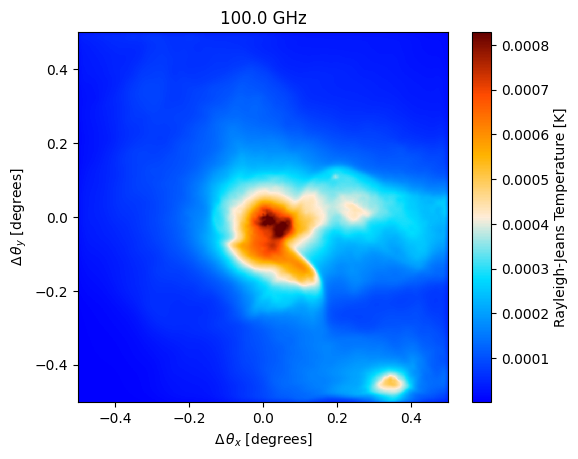

In [3]:
from maria.io import fetch
map_filename = fetch("maps/big_cluster.fits")

input_map = maria.map.read_fits(filename=map_filename, 
                                width=1., #degrees
                                index=1,
                                center=(300.0, -10.0), #RA and Dec in degrees
                                units ='Jy/pixel'
                               )

input_map.to(units="K_RJ").plot()

### Define the observing plan

To make predictions for AtLAST, several adjustments are required. Firstly, we need to change the pointing center. AtLAST is located in the southern hemisphere, so we set the pointing center to a Declination of -10. Additionally, we change the observing date. The default is set to mid-February at 6 am UT, an ideal time for observing with MUSTANG-2 on the GBT but not for AtLAST at Chajnantor. To achieve this, we modify the `start_time` key to August. This change also necessitates adjusting the Right Ascension (RA) of the pointing to ensure that the source remains above the horizon during the observation.

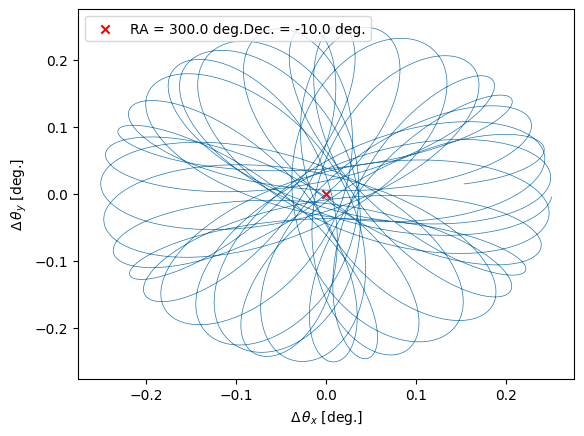

In [4]:
plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                      duration=60, # in seconds
                      sample_rate=225, # in Hz
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")
plan.plot()

### Define the instrument
We set the field of view to 1 degree and set the daisy scan's scan radius to 0.5 degrees. We also adjust the detector bandwidth to 52 GHz.

Now, it's important to note that simulating such a large FoV and spacing the detectors at 2 f-lambda results in a large detector counts. Therefore, we are simulating ~10000 detectors! This creates a bit of memory issue. Therefore, this simulation cannot (most likely) be run on your laptop but needs a bigger server

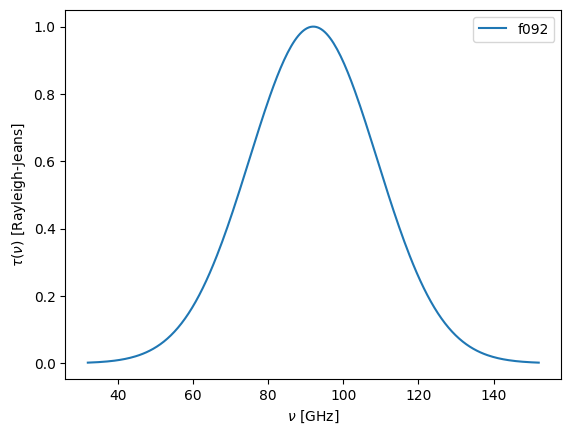

In [5]:
from maria.instrument import Band

f090 = Band(center=92, # in GHz
            width=40.0,
            knee=1,
            sensitivity=6e-5) # in K sqrt(s)
f090.plot()

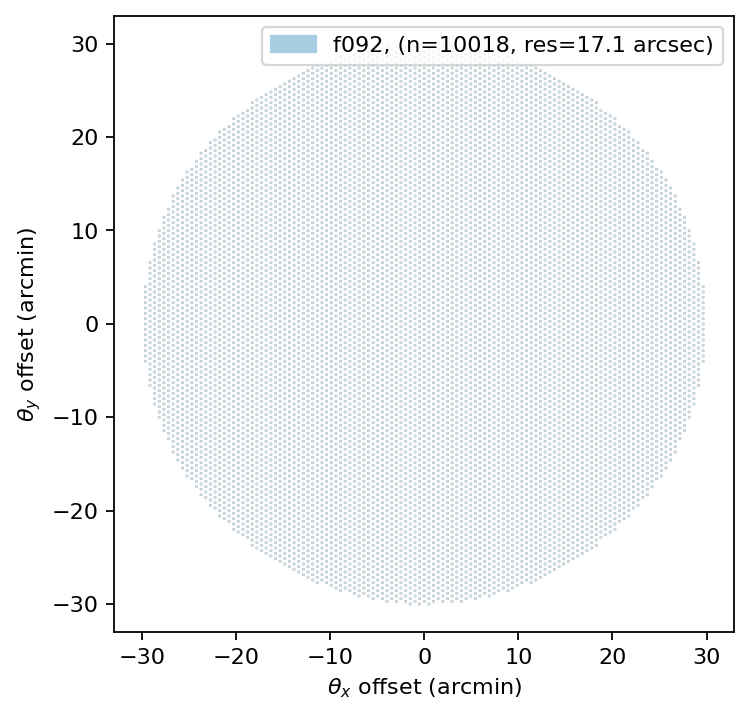

In [6]:
array = {"field_of_view": 1.0, "bands": [f090]}
instrument = maria.get_instrument(array=array, primary_size=50, beam_spacing = 2)
instrument.plot()

### Combine it and get the TOD

In [8]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                       cmb="generate",
                      )

2024-06-19 21:46:46.577 INFO: Constructed instrument.
2024-06-19 21:46:46.584 INFO: Constructed plan.
2024-06-19 21:46:46.589 INFO: Constructed site.
2024-06-19 21:46:47.506 INFO: Constructed boresight.
2024-06-19 21:46:52.459 INFO: Constructed offsets.


Initialized base in 5882 ms.


Generating CMB:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s]2024-06-19 21:46:58.670 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
2024-06-19 21:46:58.671 INFO: -> fwhm is 0.000000 arcmin
Generating CMB: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


In [9]:
tod = sim.run()

Generating noise: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.67s/it]
Generating atmosphere: 4it [00:07,  1.98s/it]
Sampling map (f092): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.27s/it]


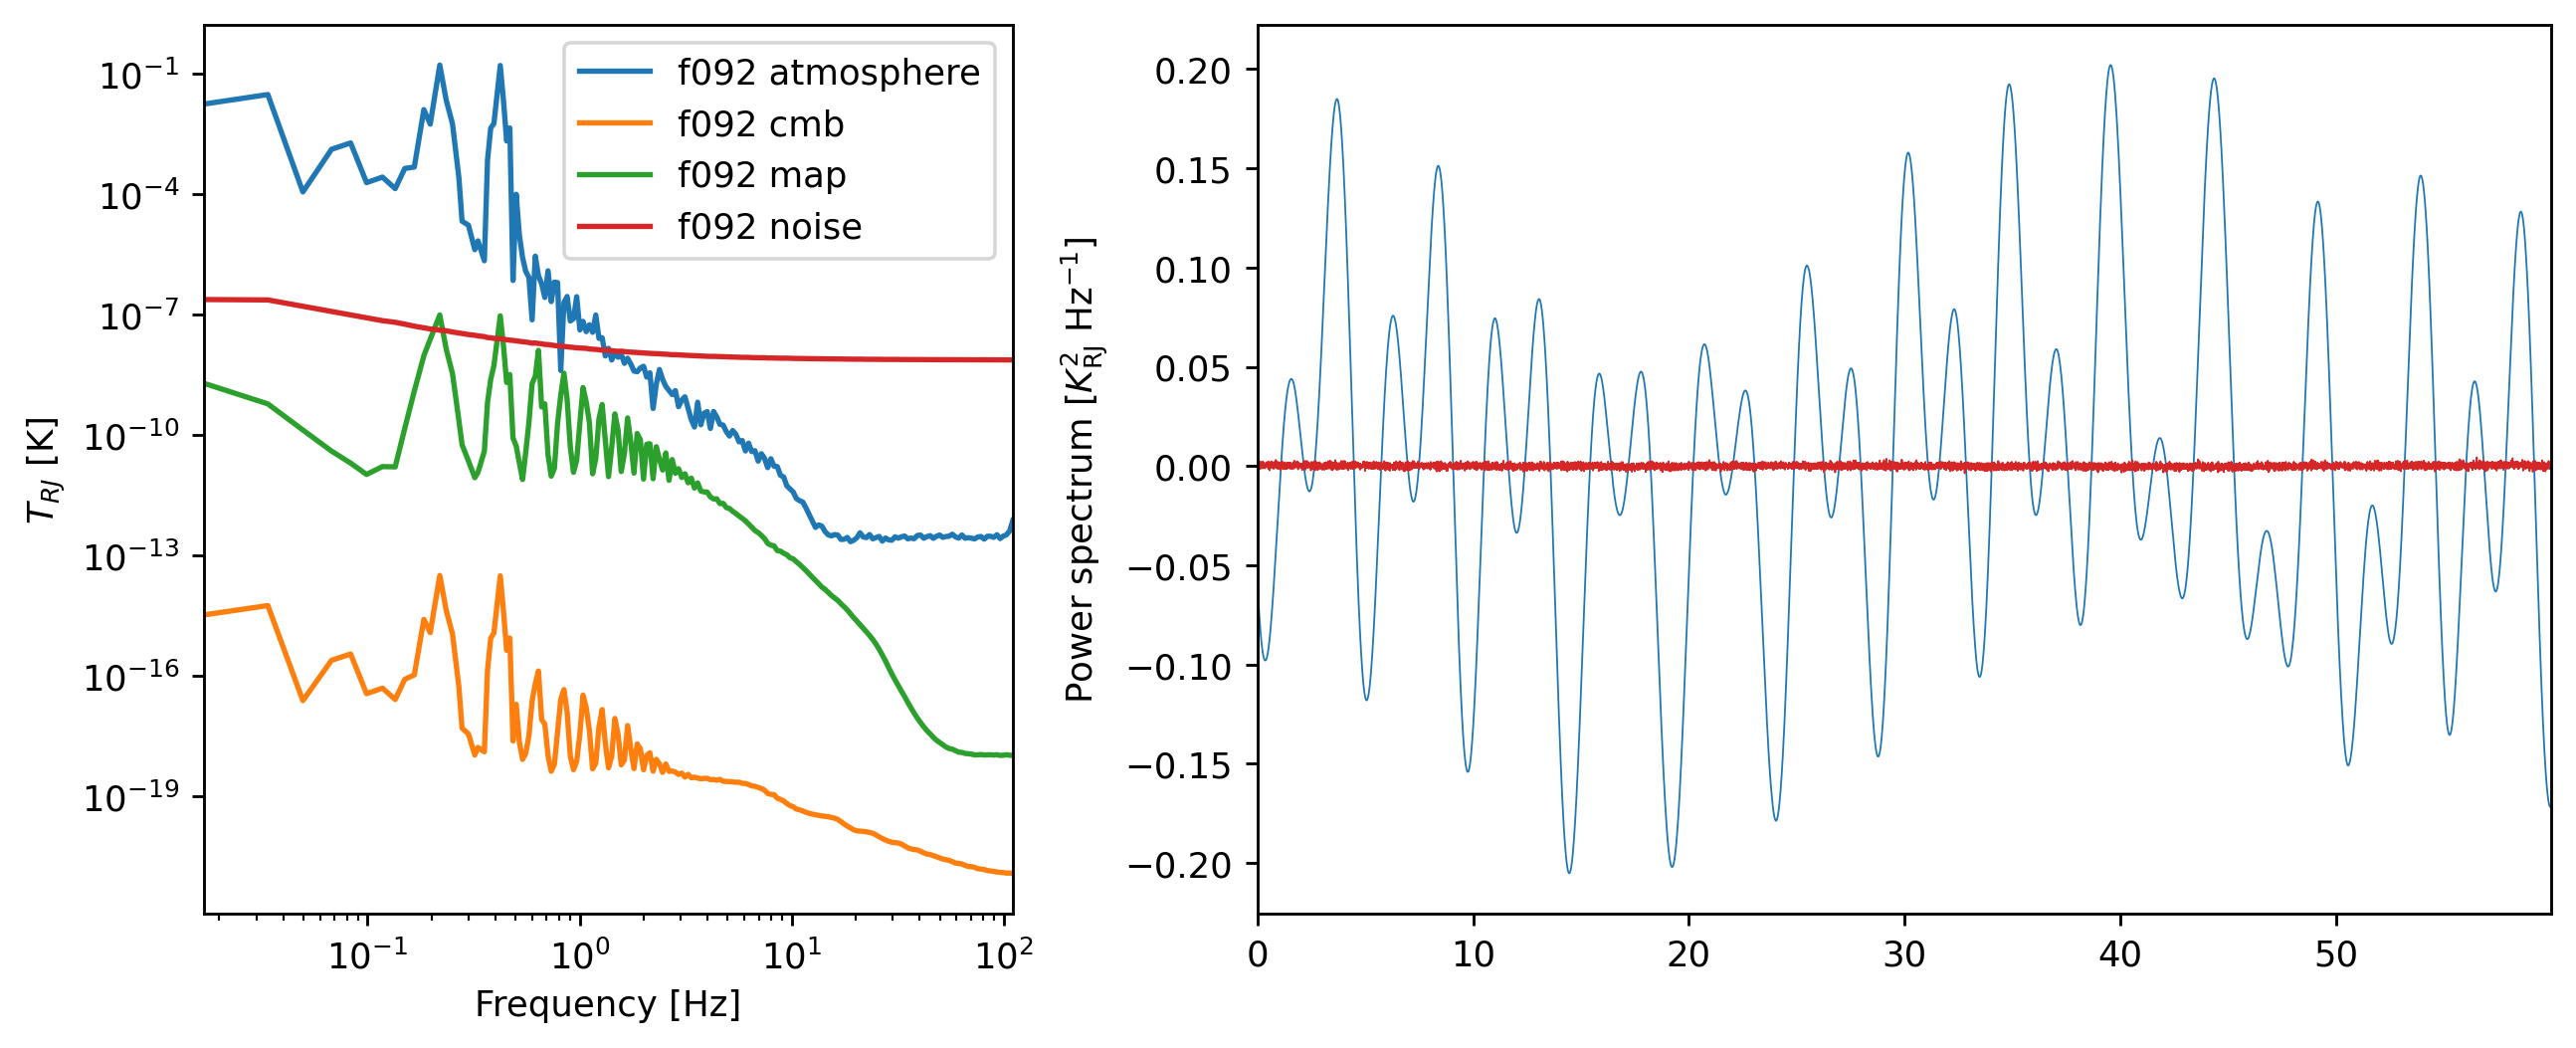

In [13]:
tod.plot()

### Visualizing the TOD Data

In this section, we present the same array and TOD visualizations as in the MUSTANG-2 case, but this time for AtLAST:

## Map-Making

The mapper we used is similar to the M2 case, it is just binned over a much larger FoV.

In [11]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(300.0, -10.0), 
                   frame="ra_dec", 
                   width=1., 
                   height=1.,
                   resolution=np.degrees(np.nanmin(instrument.fwhm))/4.,
                   tod_postprocessing={
                        "window": {"tukey": {"alpha": 0.1}},
                        "remove_modes": {"n": 1},
                        "highpass": {"f": 0.05},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)

output_map = mapper.run()

Running mapper (f092): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:14<00:00, 134.89s/it]


### Let's show the results

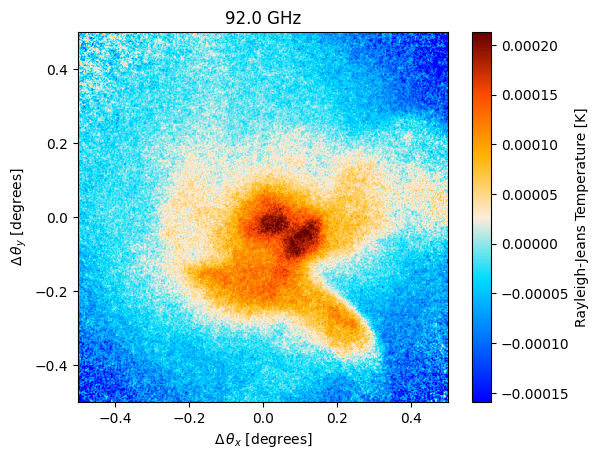

In [12]:
output_map.plot()

In [14]:
output_map.to_fits('/tmp/simulated_map.fits')